# Markov Chain Monte Carlo

In [1]:
import itertools

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

# Utility functions

In [2]:
def acf(trace, lag):
    '''
    Autocorrelation function, based on Pearson correlation
    coefficient.
    '''
    correlation, _ = stats.stats.pearsonr(trace[:-lag], trace[lag:])
    return correlation


def ess(trace):
    '''
    Effective sample size, as defined in Kruschke's "Doing
    Bayesian Data Analysis", 2nd edition, p. 184.
    '''
    significant_autocorrelations = []
    for lag in itertools.count(start=1):
        autocorrelation = acf(trace, lag)
        significant_autocorrelations.append(autocorrelation)
        if autocorrelation < 0.05:
            break
    N = len(trace)
    denominator = 1 + 2 * sum(significant_autocorrelations)
    return N / denominator


def acceptance_ratio(trace, min_diff=0.0001):
    diffs = np.array(trace[1:]) - np.array(trace[:-1])
    abs_diff = np.abs(diffs)
    not_accepted_steps = abs_diff < min_diff
    return 1 - sum(not_accepted_steps) / (len(trace) - 1)

# Exercise 1

Use metropolis algorithm to infer posterior distribution. Compare different proposal standard deviations to using trace analysis.

In [3]:
data = [0] * 6 + [1] * 14
prior = stats.beta(1, 1).pdf


def likelihood(theta, data):
    '''Bernoulli likelihood function'''
    if theta > 1 or theta < 0:
        return 0
    z = sum(data)
    N = len(data)
    return theta ** z * (1 - theta) ** (N - z)


# Define the relative probability of the target distribution,
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_relative_probability(theta, data):
    return likelihood(theta, data) * prior(theta)


def metropolis(target_prob, proposal_sd, starting_point=.1,
               trace_length=50000, burn_in=5000):
    '''
    Run a simple Metrolopis MCMC algorithm with normal deviated
    proposal.
    '''
    trace = [starting_point]
    while len(trace) < trace_length:
        current_position = trace[-1]
        proposed_jump = np.random.normal(0, proposal_sd)
        proposed_position = current_position + proposed_jump
        current_prob = target_prob(current_position, data)
        proposed_prob = target_prob(proposed_position, data)
        acceptance_prob = min(1, proposed_prob / current_prob)
        if np.random.uniform() < acceptance_prob:
            next_position = proposed_position
        else:
            next_position = current_position
        trace.append(next_position)
    return trace[burn_in:]

Use the above code to generate traces for this exercise, as well as the next one.

In [4]:
trace_proposal_sd002 = metropolis(target_prob=target_relative_probability,
                                  proposal_sd=.02)
trace_proposal_sd02 = metropolis(target_prob=target_relative_probability,
                                 proposal_sd=.2)
trace_proposal_sd2 = metropolis(target_prob=target_relative_probability,
                                proposal_sd=2)

In [5]:
def plot_trace_analysis(trace):
    effective_size = ess(trace)
    acc_ratio = acceptance_ratio(trace)

    plt.figure(figsize=(8, 6))
    plt.subplot(3, 1, 1)
    plt.title('Eff.Sz == {:.1f}'.format(effective_size))
    sns.distplot(trace)
    plt.xlabel('theta')

    plt.subplot(3, 1, 2)
    plt.title('End of chain')
    plt.plot(trace[-100:], range(100))
    plt.text(.01, 80, 'Acceptance ratio == {:.3f}'.format(acc_ratio))
    plt.xlim([0, 1])
    plt.gca().set_yticklabels([])
    plt.xlabel('theta')

    plt.subplot(3, 1, 3)
    plt.title('Beginning of chain')
    plt.plot(trace[:100], range(100))
    plt.xlim([0, 1])
    plt.gca().set_yticklabels([])
    plt.xlabel('theta')
    
    plt.tight_layout()

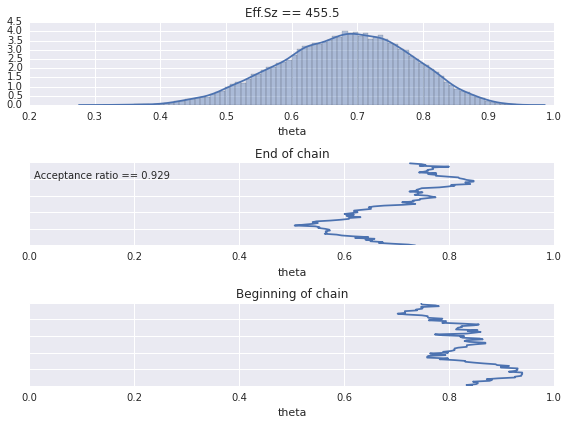

In [6]:
plot_trace_analysis(trace_proposal_sd002)

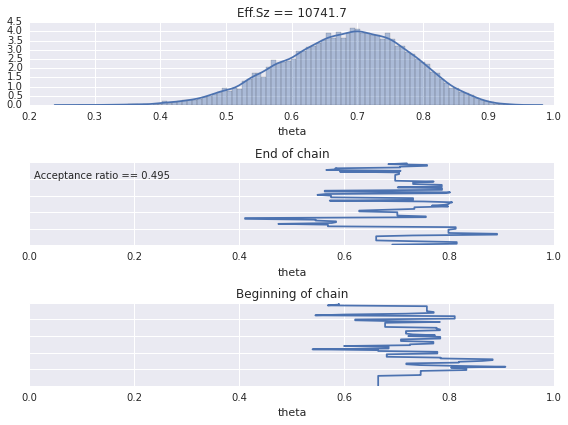

In [7]:
plot_trace_analysis(trace_proposal_sd02)

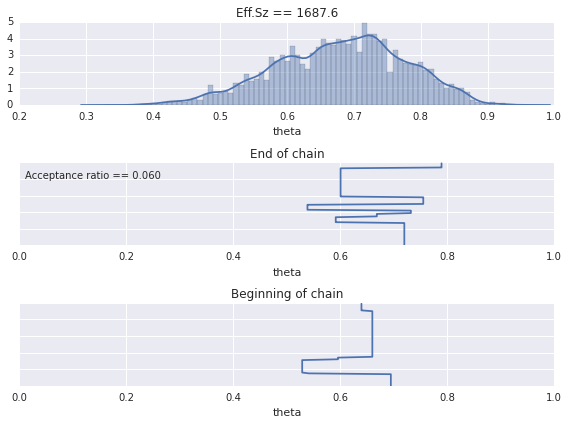

In [8]:
plot_trace_analysis(trace_proposal_sd2)

# Exercise 2

Rewrite some of Kruschke's analysis plots in python and use them on the last exercise traces.

In [9]:
def plot_trace_lag_analysis(trace, lag_examples=[2, 5, 10], max_lag=30):
    # Lags to compute autocorrelation for
    autocorrelation = [acf(trace, lag) for lag in range(1, max_lag + 1)]

    plt.figure(figsize=(10, 10))

    # Plot results for different lags
    for column, example_lag in enumerate(lag_examples, start=1):

        # Lag example plots of traces and spread
        truncated_trace = trace[:100]
        head_trace = truncated_trace[:-example_lag]
        tail_trace = truncated_trace[example_lag:]

        # Plotting
        plt.subplot(3, len(lag_examples), column)
        plt.plot(head_trace)
        plt.plot(tail_trace)
        plt.title('Lag == {}'.format(example_lag))

        example_lag_acf = autocorrelation[example_lag - 1]
        plt.subplot(3, len(lag_examples), column + len(lag_examples))
        plt.scatter(tail_trace, head_trace)
        plt.title('ACF({}) == {:.3f}'.format(example_lag, example_lag_acf))
        plt.ylim([0, 1])
        plt.xlim([0, 1])
        plt.xlabel('lagged value')
        plt.ylabel('value')

    # Autocorrelation plotting
    plt.subplot(3, 1, 3)
    plt.bar(list(range(1, max_lag + 1)), autocorrelation)
    plt.xlim([1, max_lag])
    plt.title('Trace autocorrelation')
    plt.xlabel('lag')
    plt.ylabel('ACF')

    plt.tight_layout()

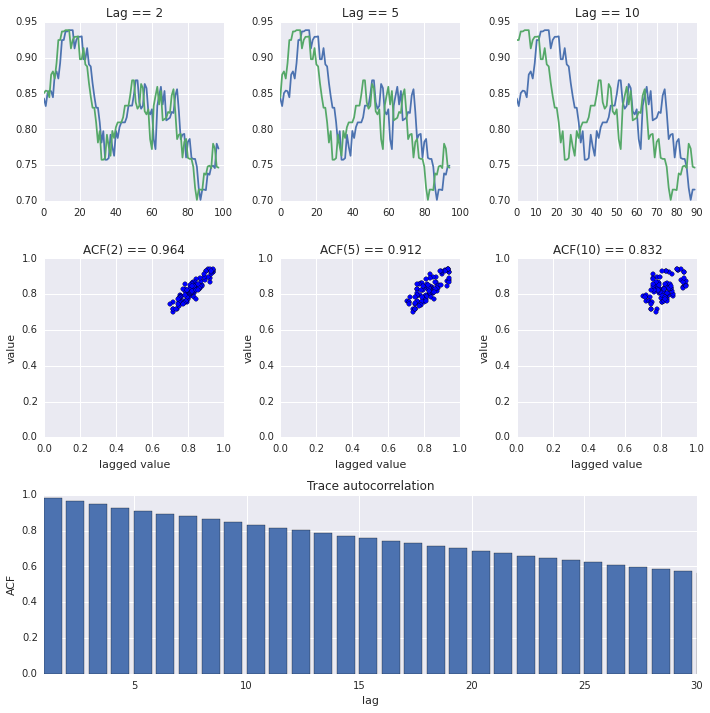

In [10]:
plot_trace_lag_analysis(trace_proposal_sd002)

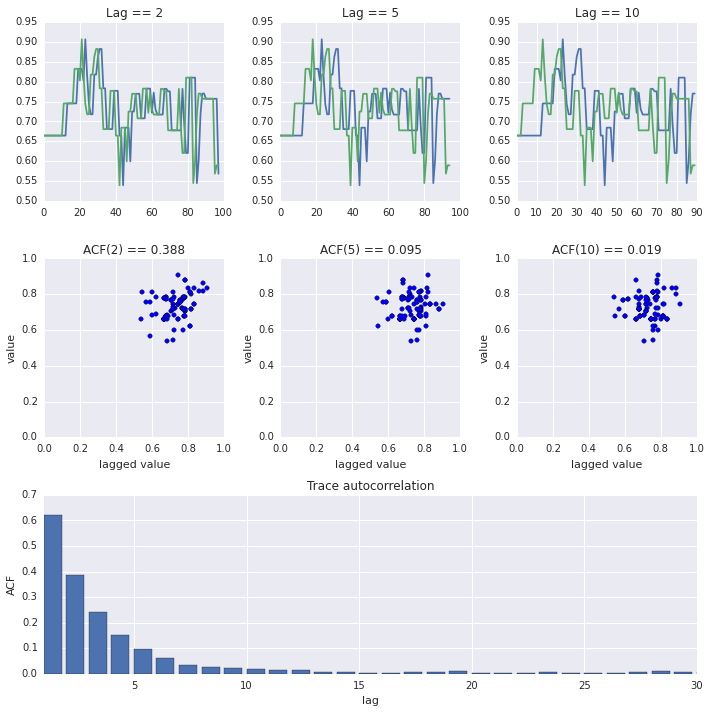

In [11]:
plot_trace_lag_analysis(trace_proposal_sd02)

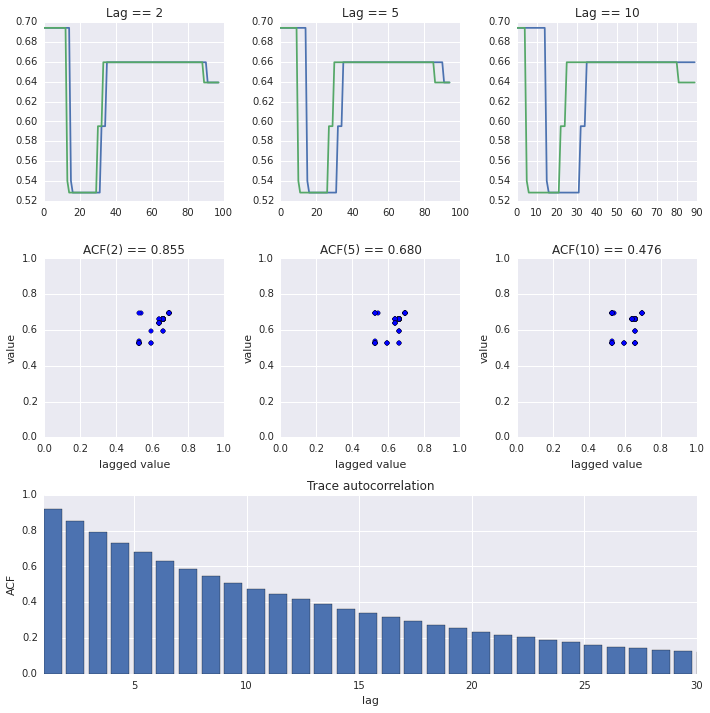

In [12]:
plot_trace_lag_analysis(trace_proposal_sd2)

# Exercise 3

Understand multimodal prior effects on the posterior through traces analysis.

### Questions A + B

Define an irregular prior and plot it.

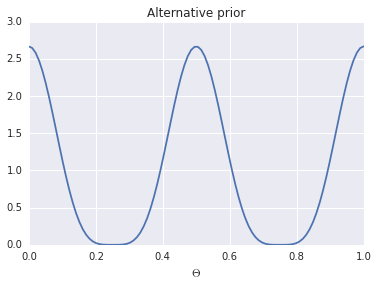

In [13]:
def prior(theta):
    return (np.cos(4 * np.pi * theta) + 1) ** 2 / 1.5

x = np.linspace(0, 1, 100)
plt.plot(x, prior(x))
plt.title('Alternative prior')
_ = plt.xlabel('$\Theta$')

### Question C

Testing the posterior using the prior above.

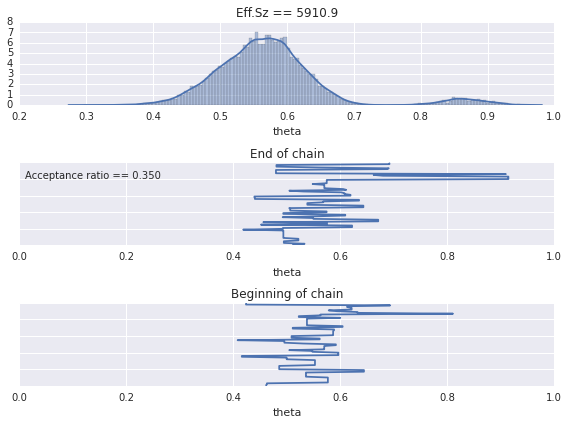

In [14]:
# Update the target probability to use the new prior
def target_relative_probability(theta, data):
    return likelihood(theta, data) * prior(theta)


trace = metropolis(target_relative_probability, proposal_sd=0.2)
plot_trace_analysis(trace)

### Question D

Using the prior above to infer posterior for different data.

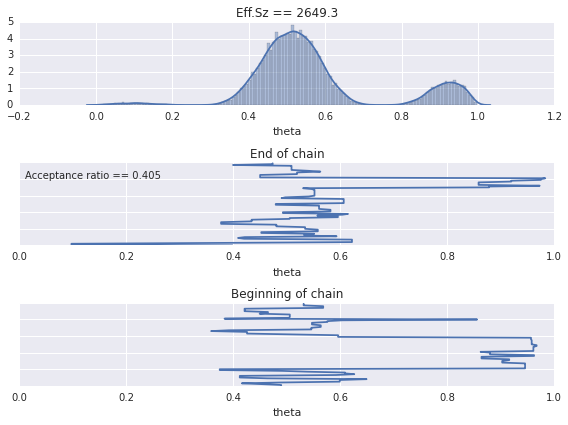

In [15]:
data = (0, 1, 1)


# Update the target probability again to use the new data
def target_relative_probability(theta, data):
    return likelihood(theta, data) * prior(theta)


trace = metropolis(target_relative_probability, proposal_sd=0.2)
plot_trace_analysis(trace)

### Question E

Same as the above, but with smaller proposal standard deviation. Notice how the algorithm stucked on only some of the modes of the multimodal prior.

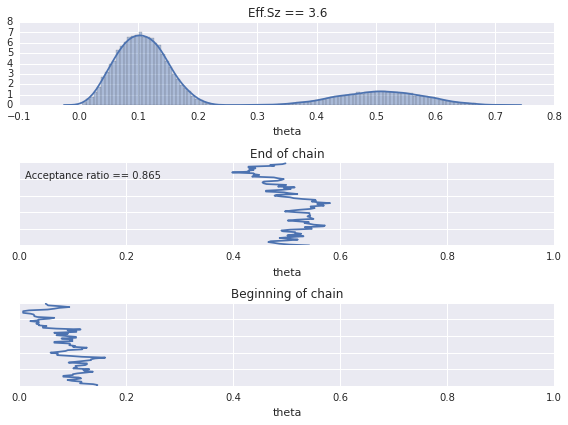

In [16]:
trace = metropolis(target_relative_probability, proposal_sd=0.02)
plot_trace_analysis(trace)

### Question F

Same as before (too small proposal standard deviation), but know with another starting point. The result posterior is completely different, as the algorithm now stucked at another mode of the prior.

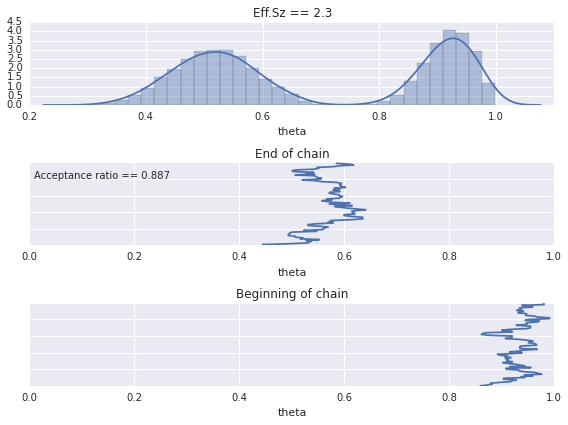

In [17]:
trace = metropolis(target_relative_probability, proposal_sd=0.02, starting_point=.99)
plot_trace_analysis(trace)